# Purpose:
- For presentation 12/01
- To show example of neural encoding in the simplest form
- Average response
- GLM (Using Alex's model)

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorOphysProjectCache as bpc
from allensdk.brain_observatory.behavior.behavior_ophys_experiment import BehaviorOphysExperiment
from brain_observatory_qc.data_access import from_lims
import seaborn as sns
import json
from pprint import pprint
from visual_behavior.data_access import loading
import bz2
import pickle
import xarray as xr
from importlib import reload

import sys
sys.path.append(r'C:\Users\jinho.kim\Github\visual_behavior_glm')
import visual_behavior_glm.GLM_analysis_tools as gat
import visual_behavior_glm.GLM_fit_tools as gft
from visual_behavior_glm.glm import GLM

from tqdm.notebook import tqdm

alex_result_dir = Path(r'\\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\ophys_glm\v_24_events_all_L2_optimize_by_session')
alex_result_df = pd.read_pickle(alex_result_dir / 'results.pkl')
alex_run_param = json.load(open(alex_result_dir / 'run_params.json', 'r'))

In [2]:
oeid = 879331157
session, fit, design = gft.load_fit_experiment(oeid, alex_run_param)

loading fit
loading sdk object
loading from lims, exclude_invalid_rois = True


c:\users\jinho.kim\github\allensdk\allensdk\brain_observatory\behavior\data_objects\stimuli\presentations.py:48: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  presentations.index = pd.Int64Index(
c:\users\jinho.kim\github\allensdk\allensdk\brain_observatory\behavior\data_objects\eye_tracking\rig_geometry.py:233: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  rig_geometry = pd.read_sql(query, lims_db.get_connection())
c:\users\jinho.kim\github\allensdk\allensdk\brain_observatory\behavior\data_objects\cell_specimens\cell_specimens.py:260: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQL

    Adding kernel: intercept
    Adding kernel: hits
    Adding kernel: misses
    Adding kernel: passive_change
	Error encountered while adding kernel for passive_change. Attemping to continue without this kernel.
	Passive Change kernel cant be added to active sessions
    Adding kernel: omissions
    Adding kernel: running
                 : Mean Centering
                 : Standardized to unit variance
    Adding kernel: pupil
                 : Mean Centering
                 : Standardized to unit variance
    Adding kernel: licks
    Adding kernel: image0
    Adding kernel: image1
    Adding kernel: image2
    Adding kernel: image3
    Adding kernel: image4
    Adding kernel: image5
    Adding kernel: image6
    Adding kernel: image7
The following kernels failed to be added to the model: 
{'passive_change'}

The following dropouts failed to be added to the model: 
{'single-passive_change'}

Checked weight/kernel lengths against timesteps per stimulus


In [6]:
fit['dropouts'].keys()

dict_keys(['Full', 'intercept', 'hits', 'misses', 'omissions', 'running', 'pupil', 'licks', 'image0', 'image1', 'image2', 'image3', 'image4', 'image5', 'image6', 'image7', 'visual', 'all-images', 'task', 'behavioral', 'all-omissions', 'single-hits', 'single-misses', 'single-omissions', 'single-running', 'single-pupil', 'single-licks', 'single-image0', 'single-image1', 'single-image2', 'single-image3', 'single-image4', 'single-image5', 'single-image6', 'single-image7', 'single-visual', 'single-all-images', 'single-task', 'single-behavioral', 'single-all-omissions'])

In [20]:
include_ind =  np.where(~np.isinf(np.mean(fit['dropouts']['Full']['cv_var_test'],1)))[0]


In [18]:
fit['dropouts']['Full']['cv_var_test'].shape

(83, 5)

In [17]:
np.where(np.isinf(fit['dropouts']['Full']['cv_var_test']))[0]

array([78, 78], dtype=int64)

(array([ 3., 48., 14.,  4.,  7.,  2.,  1.,  1.,  1.,  1.]),
 array([-0.05933983, -0.01729509,  0.02474964,  0.06679437,  0.1088391 ,
         0.15088383,  0.19292856,  0.23497329,  0.27701802,  0.31906275,
         0.36110748]),
 <BarContainer object of 10 artists>)

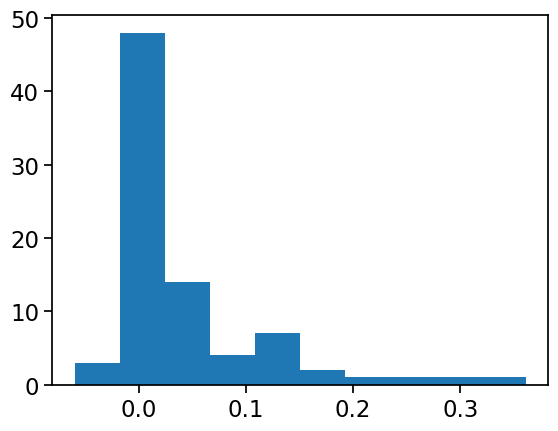

In [25]:
plt.hist(np.mean(fit['dropouts']['image0']['cv_var_test'], axis=1)[include_ind])

(array([ 3., 47., 16.,  5.,  4.,  3.,  1.,  1.,  1.,  1.]),
 array([-0.05922021, -0.01716916,  0.02488189,  0.06693294,  0.10898399,
         0.15103504,  0.19308609,  0.23513714,  0.27718819,  0.31923924,
         0.36129029]),
 <BarContainer object of 10 artists>)

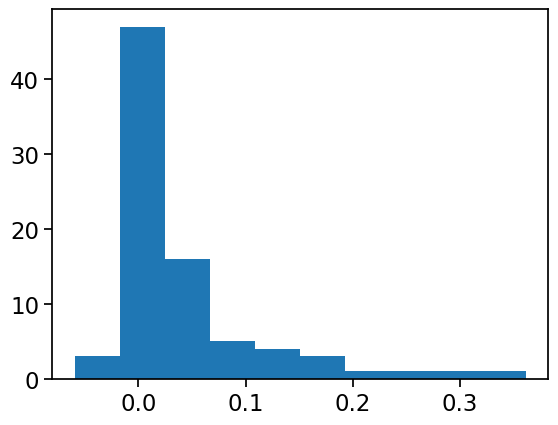

In [26]:
plt.hist(np.mean(fit['dropouts']['hits']['cv_var_test'], axis=1)[include_ind])

In [29]:
exp_result_df = alex_result_df.query('ophys_experiment_id == @oeid')

In [39]:
exp_result_df.dropout.unique()

array(['Full', 'all-images', 'all-omissions', 'behavioral', 'hits',
       'image0', 'image1', 'image2', 'image3', 'image4', 'image5',
       'image6', 'image7', 'intercept', 'licks', 'misses', 'omissions',
       'pupil', 'running', 'single-all-images', 'single-all-omissions',
       'single-behavioral', 'single-hits', 'single-image0',
       'single-image1', 'single-image2', 'single-image3', 'single-image4',
       'single-image5', 'single-image6', 'single-image7', 'single-licks',
       'single-misses', 'single-omissions', 'single-pupil',
       'single-running', 'single-task', 'single-visual', 'task', 'visual'],
      dtype=object)

In [158]:
exp_result_df.columns

Index(['dropout', 'absolute_change_from_full', 'avg_L2_regularization',
       'variance_explained', 'variance_explained_full',
       'avg_cv_var_test_full_comparison_raw', 'avg_cv_var_test_raw',
       'avg_cv_var_test_sem', 'cell_L2_regularization',
       'fraction_change_from_full', 'shuffle_cells', 'shuffle_time',
       'cell_specimen_id', 'adj_fraction_change_from_full', 'adj_dropout_raw',
       'adj_variance_explained', 'adj_variance_explained_full',
       'avg_cv_adjvar_test_full_comparison_raw', 'avg_cv_adjvar_test_raw',
       'cell_roi_id', 'glm_version', 'ophys_experiment_id', 'ophys_session_id',
       'entry_time_utc', 'equipment_name', 'full_genotype', 'mouse_id',
       'reporter_line', 'driver_line', 'sex', 'age_in_days', 'cre_line',
       'indicator', 'session_number', 'prior_exposures_to_session_type',
       'prior_exposures_to_image_set', 'prior_exposures_to_omissions',
       'behavior_session_id', 'ophys_container_id', 'project_code',
       'imaging_depth',

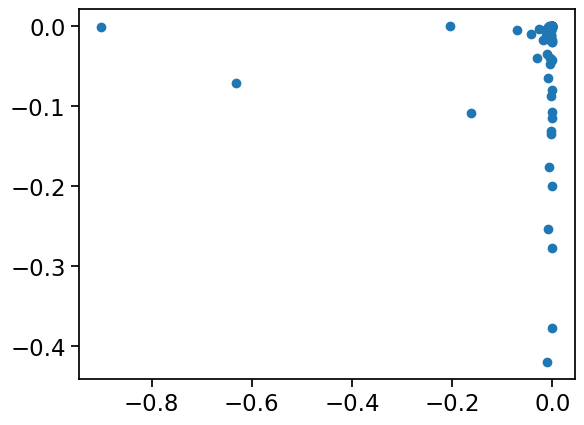

In [159]:
image0_cs = exp_result_df.query('dropout == "image1"').fraction_change_from_full.values
hits_cs = exp_result_df.query('dropout == "task"').fraction_change_from_full.values
plt.scatter(image0_cs, hits_cs)

In [160]:
ind = np.where((image0_cs < -0.6) & (hits_cs < -0.05))[0]
ind

array([45], dtype=int64)

In [161]:
csid = exp_result_df.query('dropout == "image1"').iloc[ind].cell_specimen_id.values[0]
image_name = session.stimulus_presentations.query('image_index == 1').image_name.unique()[0]
image_times = session.stimulus_presentations.query('image_name == @image_name').start_time.values

In [128]:
# pre_image_frames = 3
# post_image_frames = 20
# image_start_frame_nums = np.searchsorted(session.ophys_timestamps, image_times)
# plot_start_frame_nums = image_start_frame_nums - pre_image_frames
# plot_end_frame_nums = image_start_frame_nums + post_image_frames

# frame_rate = np.mean(np.diff(session.ophys_timestamps))
# xvalues = np.arange(-pre_image_frames, post_image_frames) * frame_rate

In [162]:
X = design.get_X()
pre_image_frames = 3
post_image_frames = 20
weight_name = 'image1_0'
image_start_frame_nums = np.where(X.loc[:, weight_name])[0]
plot_start_frame_nums = image_start_frame_nums - pre_image_frames
plot_end_frame_nums = image_start_frame_nums + post_image_frames

frame_rate = np.mean(np.diff(X.timestamps.values))
xvalues = np.arange(-pre_image_frames, post_image_frames) * frame_rate

Text(0, 0.5, 'Filtered events')

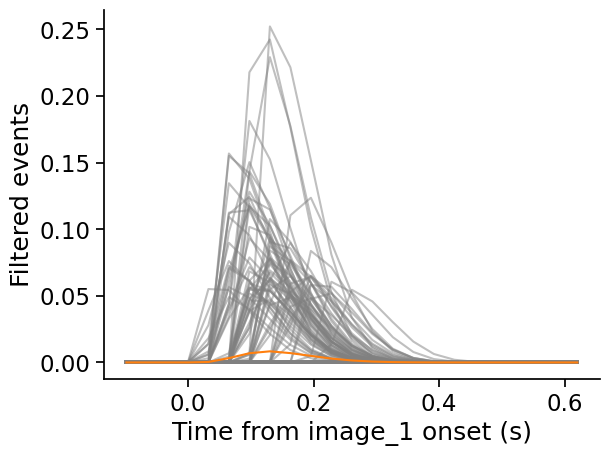

In [168]:
# fevents = session.events.loc[csid].filtered_events.values[0]
fevents = fit['fit_trace_arr'].loc[:,csid]
all_response = [fevents[plot_start_frame_nums[i]:plot_end_frame_nums[i]] for i in range(len(image_start_frame_nums))]
mean_response = np.nanmean(all_response, axis=0)
std_response = np.std(all_response, axis=0)
fig, ax = plt.subplots()
for i in range(len(image_start_frame_nums)):
    ax.plot(xvalues, fevents[plot_start_frame_nums[i]:plot_end_frame_nums[i]], color='gray', alpha=0.5)
ax.plot(xvalues, mean_response, color='C1')
# ax.fill_between(xvalues, mean_response-std_response, mean_response+std_response, color='C1', alpha=0.5)
# remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Time from image_1 onset (s)')
ax.set_ylabel('Filtered events')

Text(0.5, 1.0, 'With hits')

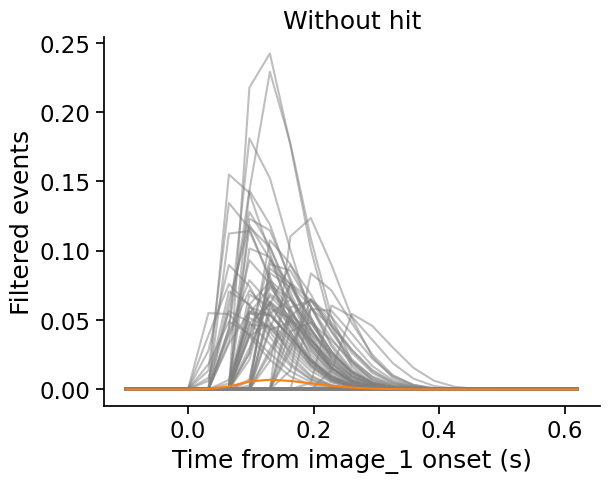

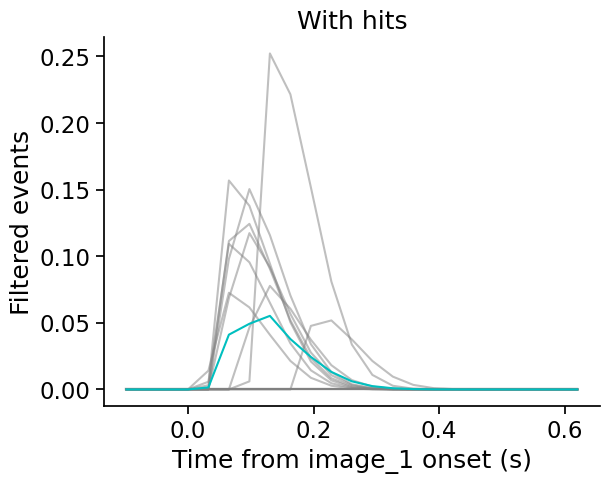

In [181]:
hit_start_frame_nums = np.where(X.loc[:, 'hits_0'])[0]
image_hit_start_frame_nums = np.intersect1d(image_start_frame_nums, hit_start_frame_nums)
image_not_hit_start_frame_nums = np.setdiff1d(image_start_frame_nums, hit_start_frame_nums)

image_plot_start_frame_nums = image_not_hit_start_frame_nums - pre_image_frames
image_plot_end_frame_nums = image_not_hit_start_frame_nums + post_image_frames
hit_plot_start_frame_nums = image_hit_start_frame_nums - pre_image_frames
hit_plot_end_frame_nums = image_hit_start_frame_nums + post_image_frames

image_all_response = [fevents[image_plot_start_frame_nums[i]:image_plot_end_frame_nums[i]] for i in range(len(image_not_hit_start_frame_nums))]
image_mean_response = np.mean(image_all_response, axis=0)
image_std_response = np.std(image_all_response, axis=0)

hit_all_response = [fevents[hit_plot_start_frame_nums[i]:hit_plot_end_frame_nums[i]] for i in range(len(image_hit_start_frame_nums))]
hit_mean_response = np.mean(hit_all_response, axis=0)
hit_std_response = np.std(hit_all_response, axis=0)

fig, ax = plt.subplots()
for i in range(len(image_all_response)):
    ax.plot(xvalues, image_all_response[i], color='gray', alpha=0.5)
ax.plot(xvalues, image_mean_response, color='C1')
# ax.fill_between(xvalues, image_mean_response-image_std_response, image_mean_response+image_std_response, color='C1', alpha=0.5)
# remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Time from image_1 onset (s)')
ax.set_ylabel('Filtered events')
ax.set_title('Without hit')

fig, ax = plt.subplots()
for i in range(len(hit_plot_start_frame_nums)):
    ax.plot(xvalues, fevents[hit_plot_start_frame_nums[i]:hit_plot_end_frame_nums[i]], color='gray', alpha=0.5)
ax.plot(xvalues, hit_mean_response, color='c')
# ax.fill_between(xvalues, hit_mean_response-hit_std_response, hit_mean_response+hit_std_response, color='c', alpha=0.5)
# remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Time from image_1 onset (s)')
ax.set_ylabel('Filtered events')
ax.set_title('With hits')
